In [575]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

args=Namespace(rho=0,
               seed=9384,
              npop=1e4,
              mu=1e-08,
              m=0.05,
              ndemes=5,
              tmove=100,
              ss=50)

In [373]:
import msprime
import numpy as np
import statistics
import math
import allel
import pandas as pd
import statsmodels.api as sm
from scipy import (stats,ndimage)

In [658]:
# set up the initial population
ss_each=args.ss*2
sample_sizes=[ss_each]*5

population_configurations = [
msprime.PopulationConfiguration(sample_size=k)
for k in sample_sizes]

def fmig( m, ndemes):
    migration_matrix = np.full( (ndemes,ndemes), m)
    np.fill_diagonal(migration_matrix, 0)
    return migration_matrix

def fmig2(m, ndemes):
    migration_matrix = np.zeros( (ndemes,ndemes) )
    migration_matrix[0,1] = migration_matrix[1,0] = m
    return migration_matrix

#population_configurations.extend([msprime.PopulationConfiguration(sample_size=0)]*3)

migration_matrix = fmig2(0.003, ndemes=args.ndemes)

In [659]:
migration_matrix

array([[0.   , 0.003, 0.   , 0.   , 0.   ],
       [0.003, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ]])

In [660]:
migration_matrix.shape

(5, 5)

In [661]:
demog_list=[
    
    #ancient history
    #t 4500: Migrate lineages from 35 > 36 (WHG-south to Steppe) & from 0 > 36 (WHG1 to steppe)
    [msprime.MassMigration(time=4500, source=1, destination=2, proportion=0.2)],
    [msprime.MassMigration(time=4501, source=0, destination=2, proportion=0.5)],

    #t 7510: Migrate lineages from 35 > 38 (WHG-south > EF) & 0>38 (WHG-n > EF)
    [msprime.MassMigration(time=7510, source=1, destination=4, proportion=0.75)],
    [msprime.MassMigration(time=7511, source=0, destination=4, proportion=0.4)],

    #t 9000: Migrate lineages 36 > 37: steppe to EF & WHG1 and WHG2 merge
    [msprime.MassMigration(time=9000, source=2, destination=3, proportion=0.5)],
    [msprime.MassMigration(time=9001, source=1, destination=0, proportion=1)],
    
    [msprime.MigrationRateChange(time = 9001, rate=0)],

    #t 25k: Migrate lineages 36 > 38, steppe & EF merge
    [msprime.MassMigration(time=25000, source=2, destination=4, proportion=1)],

    #t 30k: Migrate lineages 0 > 37: HG and basal Eurasians merge
    [msprime.MassMigration(time=30000, source=0, destination=3, proportion=1)],

    #t 45k: Migrate lineages 37 > 38: HG and basal Eurasians merge
    [msprime.MassMigration(time=45000, source=3, destination=4, proportion=1)]]

demog = [item for sublist in demog_list for item in sublist]

In [662]:

ts=msprime.simulate(Ne=10000,
                      population_configurations=population_configurations,
                    migration_matrix = migration_matrix,
                      mutation_rate=1e-08,
                      recombination_rate=1e-08,
                      length=1e7,
                   demographic_events=demog)

In [663]:
h = ts.genotype_matrix()

In [664]:
daf=np.mean(h,axis=1)
cm_ix=(daf > 0.05) & (daf < 0.95)

h2 = allel.HaplotypeArray(h[cm_ix,:])

In [665]:
g = h2.to_genotypes(ploidy=2)

In [666]:
g2 = g.to_n_alt()

In [667]:
g2_pruned_list = allel.locate_unlinked(g2, size=100, step=10, threshold=0.1)

In [668]:
g3 = g[g2_pruned_list,:]

In [669]:
subpops = np.array([list(range( ((i-1)*args.ss) , ((i-1)*args.ss)+args.ss)) for i in range(1,3)])


In [670]:
a,b,c =allel.weir_cockerham_fst(g3, subpops)
a = np.take(a,indices=1,axis=1)
b = np.take(b,indices=1,axis=1)
c = np.take(c,indices=1,axis=1)

denom = a+b+c
ix_0 = np.where(denom!=0)[0]
fst = np.zeros(len(a))
fst[ix_0] =  a[ix_0]/denom[ix_0]

In [671]:
np.mean(fst)

0.0019514220945304904

In [672]:
fst2 = np.sum(a)/( np.sum(a) + np.sum(b) + np.sum(c) ); fst2

0.0030201612353392107

In [673]:

reps=msprime.simulate(Ne=10000,
                      population_configurations=population_configurations,
                    migration_matrix = migration_matrix,
                      mutation_rate=1e-08,
                      recombination_rate=1e-08,
                      length=1e7,
                   demographic_events=demog,
                   num_replicates = 10)
                      

In [674]:
fstmat = np.zeros((100,1))
subpops = np.array([list(range( ((i-1)*50) , ((i-1)*50)+50)) for i in range(1,3)])

for i,ts in enumerate(reps):
    h = ts.genotype_matrix()
    daf=np.mean(h,axis=1)
    cm_ix=(daf > 0.05) & (daf < 0.95)

    h2 = allel.HaplotypeArray(h[cm_ix,:])
    g = h2.to_genotypes(ploidy=2)
    g2 = g.to_n_alt()
    g2_pruned_list = allel.locate_unlinked(g2, size=100, step=10, threshold=0.1)
    g3 = g[g2_pruned_list,:]


    a,b,c =allel.weir_cockerham_fst(g3, subpops)
    a = np.take(a,indices=1,axis=1)
    b = np.take(b,indices=1,axis=1)
    c = np.take(c,indices=1,axis=1)

    #denom = a+b+c
    #ix_0 = np.where(denom!=0)[0]
    #fst = np.zeros(len(a))
    #fst[ix_0] =  a[ix_0]/denom[ix_0]

    fst2 = np.sum(a)/( np.sum(a) + np.sum(b) + np.sum(c) )
    fstmat[i,0] = fst2
    

(array([90.,  0.,  0.,  0.,  0.,  1.,  2.,  4.,  1.,  2.]),
 array([0.        , 0.00049378, 0.00098757, 0.00148135, 0.00197513,
        0.00246892, 0.0029627 , 0.00345649, 0.00395027, 0.00444405,
        0.00493784]),
 <a list of 10 Patch objects>)

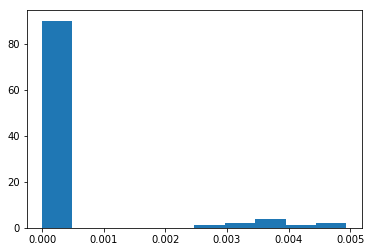

In [675]:
plt.hist(fstmat)

In [676]:
np.mean(fstmat)

0.00037648815589136716